# Elastic deformation (one disk)

## Tools

*Modules*

In [33]:
import numpy as np
from scipy.special import ellipe, ellipk
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patheffects
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmcrameri.cm as cmc

In [34]:
plt.style.use('myfig.mplstyle')

*Paths*

In [35]:
# paths
wkdir = "/Users/emile/Documents/Etude/2024_2025_M2/tutored_project"
datadir = "{:}/data".format(wkdir)
plotdir = "{:}/figures".format(wkdir)

*Functions*

In [36]:
def elastic_vertical_displacement(r, p, a, nu, E):
    """
    This function computes the vertical displacement of the
    surface generated by a uniform load over a circular area
    at a given distance.
    
    From:
    
    Verruijt, A. (2010). Elastodynamics of a Half Space.
    In: An Introduction to Soil Dynamics. Theory and Applications
    of Transport in Porous Media, vol 24. Springer,
    Dordrecht. https://doi.org/10.1007/978-90-481-3441-0_9
    
    Johnson, K. L. (1987). Contact mechanics. Cambridge University Press.

    Args:
        r (array of floats): distance at which the surface displacement is computed (m)
        p (float): load over the circular area (Pa)
        a (float): radius of the circular loaded area (m)
        nu (float): Poisson's ratio of the encasing rock
        E (float): Young's modulus of the encasing rock (Pa)
    """
    
    u = np.zeros_like(r)
    
    x = r**2/a**2
    u[r <= a] = - 4*p*a*(1-nu**2)/(np.pi*E)*ellipe(x[r <= a])
    u[r > a] = - 4*p*r[r > a]*(1-nu**2)/(np.pi*E)*(ellipe(1/x[r > a])-(1-1/x[r > a])*ellipk(1/x[r > a]))
    
    return u


def elastic_radial_displacement(r, p, a, nu, E):
    """
    This function computes the radial displacement of the
    surface generated by a uniform load over a circular area
    at a given distance.
    
    From:
    
    Verruijt, A. (2010). Elastodynamics of a Half Space.
    In: An Introduction to Soil Dynamics. Theory and Applications
    of Transport in Porous Media, vol 24. Springer,
    Dordrecht. https://doi.org/10.1007/978-90-481-3441-0_9
    
    Johnson, K. L. (1987). Contact mechanics. Cambridge University Press.

    Args:
        r (array of floats): distance at which the surface displacement is computed (m)
        p (float): load over the circular area (Pa)
        a (float): radius of the circular loaded area (m)
        nu (float): Poisson's ratio of the encasing rock
        E (float): Young's modulus of the encasing rock (Pa)
    """
    
    u = np.zeros_like(r)
    
    x = r**2/a**2
    u[r <= a] = - (1-2*nu)*(1+nu)/(2*E)*p*r[r <= a]
    u[r > a] = - (1-2*nu)*(1+nu)/(2*E)*p*a**2/r[r > a]
    
    return u

## Surface displacements : one disk

*Physical parameters*

In [37]:
# Poisson's ratio (encasing rock of the Dead Sea)
nu = .3

# Young's modulus (encasing rock of the Dead Sea)
E = 100e9 # Pa

# Gravity acceleration
g = 9.81 # m.s-2

*Load*

In [38]:
# The Dead sea has a surface of ~605 km2 (2016), which corresponds to an equivalent circle of radius 14 km
a = 14e3 #m

# We consider a 10 m decrease of the Dead Sea level (which correesponds roughly to the period 2010-2020).
# The density of the Dead Sea is ~1240 kg.m-3
# Thus we calculate the change in the load
# beware, here, the z-axis points downwards
dh_sea = - 10 # m
rho_sea = 1240 # kg.m-3

p = rho_sea * dh_sea * g

*Computation*

In [39]:
N = 1000
rmax = 150e3

# Map

x = np.linspace(-rmax, rmax, N)
y = np.linspace(-rmax, rmax, N)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2+Y**2)

Uz = elastic_vertical_displacement(R, p, a, nu, E)
Uz[R <= a] = np.nan

Ur = elastic_radial_displacement(R, p, a, nu, E)
Ur[R <= a] = np.nan
Ux = X/np.sqrt(X**2+Y**2) * Ur
Uy = Y/np.sqrt(X**2+Y**2) * Ur

In [40]:
# Profile

x0, x1 = -100e3, 100e3
y0, y1 = 0, 0

N = 1000

x_profile = x0 + np.linspace(0, 1, N) * (x1-x0)
y_profile = y0 + np.linspace(0, 1, N) * (y1-y0)

r = np.sqrt((x_profile)**2+(y_profile)**2)

uz = elastic_vertical_displacement(r, p, a, nu, E)
ur = elastic_radial_displacement(r, p, a, nu, E)

*Plot*

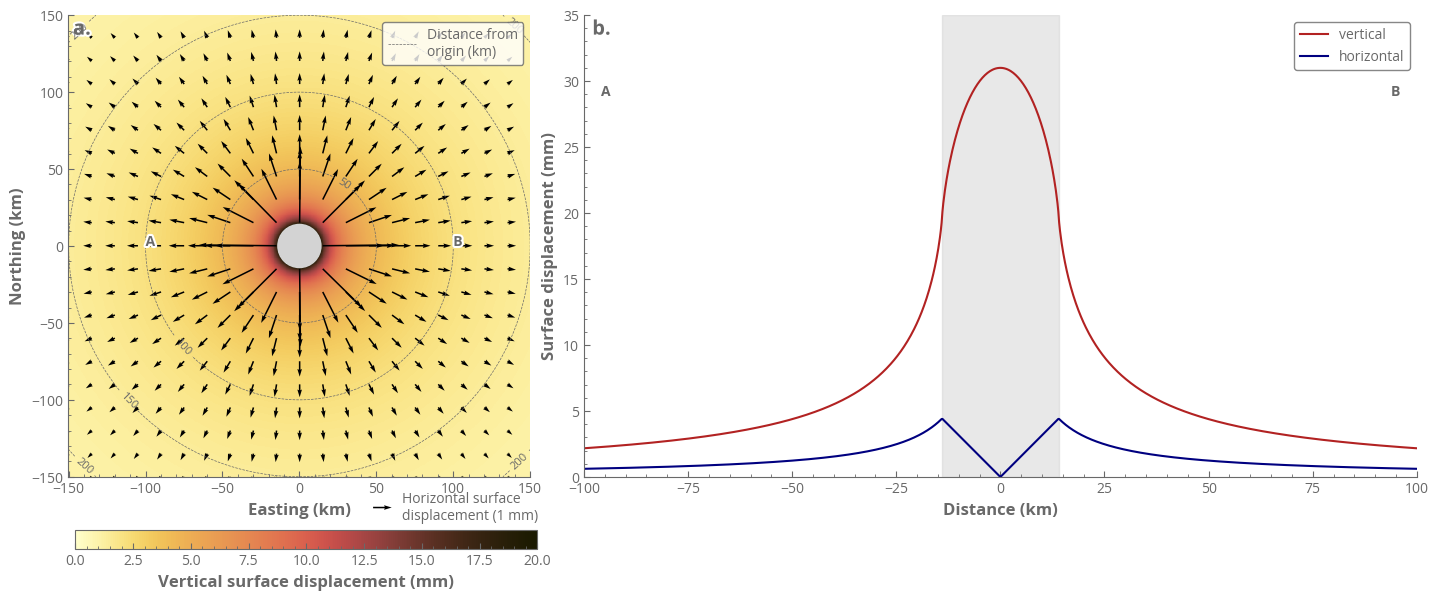

In [41]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 3]})

# Map

cmap = cmc.lajolla_r
norm = mcolors.Normalize(vmin=0, vmax=20)
mappable = cmx.ScalarMappable(norm=norm, cmap=cmap)

c = ax[0].pcolormesh(X/1e3, Y/1e3, Uz*1e3, cmap=cmap, norm=norm)
ax[0].add_patch(plt.Circle((0, 0), a/1e3, color='lightgrey'))
CS = ax[0].contour(X/1e3, Y/1e3, R/1e3, levels=[50, 100, 150, 200, 250], colors='dimgrey', linestyles='--', linewidths=.5)
ax[0].clabel(CS, fontsize=8)
ax[0].plot([], [], color='dimgrey', linestyle='--', linewidth=.5, label='Distance from\norigin (km)')

axin = inset_axes(ax[0], width="100%", height="4%", loc="lower left",
                  bbox_to_anchor=(0, -.17, 1, 1), bbox_transform=ax[0].transAxes)
cb = fig.colorbar(mappable=mappable, cax=axin, orientation='horizontal')
cb.set_label('Vertical surface displacement (mm)')

step = 50
q = ax[0].quiver(X[::step, ::step]/1e3, Y[::step, ::step]/1e3, Ux[::step, ::step], Uy[::step, ::step],
                 units='xy', width=1)
ax[0].quiverkey(q, X=60, Y=-170, U=1e-3, coordinates='data',
                label='Horizontal surface\ndisplacement (1 mm)', labelpos='E')

ax[0].text(x0/1e3, y0/1e3, 'A', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax[0].text(x1/1e3, y1/1e3, 'B', fontweight='bold', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

ax[0].set_xlabel('Easting (km)')
ax[0].set_ylabel('Northing (km)')
ax[0].legend(loc='upper right')
ax[0].set_aspect('equal')

# Profile

ax[1].plot(x_profile/1e3, uz*1e3, c='firebrick', label='vertical')
ax[1].plot(x_profile/1e3, ur*1e3, c='navy', label='horizontal')
ax[1].axvspan(-a/1e3, a/1e3, color='lightgrey', alpha=.5)

ax[1].set_xlabel('Distance (km)')
ax[1].set_xlim(x_profile.min()/1e3, x_profile.max()/1e3)
ax[1].set_ylabel('Surface displacement (mm)')
ax[1].set_ylim(0, 35)
ax[1].legend(loc='upper right')

ax[1].text(.02, .85, 'A', transform=ax[1].transAxes, fontweight="bold", va='top', ha='left')
ax[1].text(.98, .85, 'B', transform=ax[1].transAxes, fontweight="bold", va='top', ha='right')

ax[0].text(.01, .99, 'a.', size='x-large', fontweight='bold', transform=ax[0].transAxes, va='top', ha='left', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])
ax[1].text(.01, .99, 'b.', size='x-large', fontweight='bold', transform=ax[1].transAxes, va='top', ha='left', path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

plt.subplots_adjust(wspace=.01)
fig.savefig("{:}/elastic_deformation_one_disk.png".format(plotdir), dpi=300, bbox_inches='tight')
plt.show()